In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.linalg import expm
from scipy.stats import norm 
from qutip import *
import qutip as qt
import random
from sympy.physics.quantum import *
from sympy.physics.quantum.density import *
from tqdm import tqdm
import time

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Introduction 

### Resources

https://arxiv.org/pdf/2007.00473.pdf

http://xuv.scs.illinois.edu/chem540/GroupProjects/Piehl_Torres_SourcePaper.pdf page 265!

http://pound.med.utoronto.ca/lek-publications/477.pdf

https://static-content.springer.com/esm/art%3A10.1038%2Fs41534-022-00605-4/MediaObjects/41534_2022_605_MOESM1_ESM.pdf


Dipolar interaction formalism: https://groups.chem.ubc.ca/straus/l4.pdf

Homonuclear Explicit Form: http://tinyurl.com/yruvraf5

### Hamiltonians 
(without hyperfine interaction with nuclear spin)

$S_{NV} = 1$
$S_{P1} = 1/2$

$H_{NV}$ = $DS_{NV,z}^2 + \gamma_e \vec{B} \cdot \vec{S_{NV}}$

$H_{P1} = \gamma_e \vec{B}\cdot\vec{S_{P1}}$

For multiple P1 centers bath, we have 
$H_{bath} = \sum_i H_{P1, i} + \sum_{i \ne j} H_{P1,i - P1,j}$


#### Dipolar Coupling
$H_{int} = \frac{\gamma_{NV} \gamma_{P1}}{|\vec{r_k}|^3} ( \vec{S_{NV}} \cdot \vec{I_{^{15}N}}- 3(\vec{S_{NV}} \cdot \hat{n}_k)(\vec{I_{^{15}N}} \cdot \hat{n}_k)) $


This can be simplified in an external magnetic field:

Homonuclear coupling (between P1s):
$H_{P1, D} = \frac{\gamma_e^2}{2|\vec{r_i}|^3}(1 - 3\cos^2(\theta))[3 S_{P1,i, z} S_{P1,j, z} - \vec{S_{P1,i}}\cdot \vec{S_{P1,j}}]$

Heternuclear coupling (NV-P1):
$H_D = \frac{\gamma_e^2}{|\vec{r_i}|^3}(1 - 3\cos^2(\theta))(S_{NV, z} S_{P1,i, z} $)

$\cos \theta = r_z/|\vec{r}|$ ($B = B_z$)


### Our Sample:
NV: 2.5 ppm

N: 99.3 ppm

P1/NV $\approx$ 20-40

### Total Hamiltonian in the Doubly Tilted Rotating Frame

H = $\Omega_{NV} S_z - \delta_{NV} S_x + \sum_i^N (\Omega_{P1, i} I_z^i - \delta_i I_x^i) + D_iS_{z} I_{z}^i + \sum_{i \ne j} \frac{D_{ij}}{2}(3 I_{z}^i I_z^j - \vec{I^{i}}\cdot \vec{I^{j}})$ 


## Set Parameters

In [2]:
# parameters 
MHz = 1e6
kHz = 1e3
G = 1
ħ = 1

D = 2870*MHz;

# assume that B is along z for all future calculations
B_x = 0*G
B_y = 0*G
B_z = 237*G

γ_e = 2.8025*MHz/G

In [3]:
# compute the resonance frequency of the NV

# NV hamiltonian (NV), N15
Sx_NV, Sy_NV, Sz_NV = spin_Jx(1), spin_Jy(1), spin_Jz(1)
S_NV = [Sx_NV, Sy_NV, Sz_NV]

H_NV = (D*Sz_NV**2) # zero field splitting 
H_NV += γ_e*(B_x*Sx_NV + B_y*Sy_NV + B_z*Sz_NV) # NV Zeeman

eigenvalues_NV = H_NV.eigenenergies()

# resonance frequency (Hz)
ω_NV = eigenvalues_NV[1] - eigenvalues_NV[0]

In [4]:
# compute the resonance frequency of the P1

# NV hamiltonian (NV), N15
Sx_P1, Sy_P1, Sz_P1 = spin_Jx(1/2), spin_Jy(1/2), spin_Jz(1/2)
S_P1 = [Sx_P1, Sy_P1, Sz_P1]

H_P1 = γ_e*tensor(B_x*Sx_P1 + B_y*Sy_P1 + B_z*Sz_P1) # P1 Zeeman 

eigenvalues_P1 = H_P1.eigenenergies()

# resonance frequency(Hz)
ω_P1 = eigenvalues_P1[1] - eigenvalues_P1[0]

In [5]:
# define operator for P1 centers with index i and j
def P1_P1_operator(N, i, j, op_i, op_j):
    ''' Returns operator acting on P1 centers i and j
    N: total number of P1 centers 
    i: P1 index (int); i<j; start at i=1
    j: P1 index (int)
    op_i: operator acting on P1 i
    op_j: operator acting on P1 j
    '''
    # identity operator for all qubits 
    identity_ops = [identity(2) for _ in range(N + 1)]
    
    system_op = tensor(identity_ops[:i] + [op_i] + identity_ops[i + 1:j] + [op_j] + identity_ops[j+1:])
    
    return system_op


# define operator for NV center and P1 center with index i
def NV_P1_operator(N, i, op_i, op_NV):
    ''' Returns operator acting on P1 centers i and NV center
    N: total number of P1 centers 
    i: P1 index (int)
    op_i: operator acting on P1 i
    op_NV: operator acting on NV
    '''
    # identity operator for all qubits 
    identity_ops = [identity(2) for _ in range(N + 1)]
    
    system_op = tensor([op_NV] + identity_ops[1:i] + [op_i] + identity_ops[i+1:])
    
    return system_op

# define operator for NV center 
def NV_operator(N, op_NV):
    ''' Returns operator acting on P1 centers i and NV center
    N: total number of P1 centers 
    op_NV: operator acting on NV
    '''
    # identity operator for all qubits 
    identity_ops = [identity(2) for _ in range(N + 1)]
    
    system_op = tensor([op_NV] + identity_ops[1:])
    
    return system_op


# define operator for single P1 center
def P1_operator(N, i, op_i):
    ''' Returns operator acting on P1 center i
    N: total number of P1 centers 
    i: P1 index (int); start at i=1
    op_i: operator acting on P1 i
    '''
    # identity operator for all qubits 
    identity_ops = [identity(2) for _ in range(N + 1)]
    system_op = tensor(identity_ops[:i] + [op_i] + identity_ops[i + 1:])
    
    return system_op

In [6]:
def homonuclear_dipole_TDR(N, i, j, r_i, r_j):
    ''' Returns dipolar term between the P1 centers 
    
    Args:
        i: P1 center index (int)
        j: P1 center index (int)
        r_i: P1_i position (vector, double, 3 coordinates)
        r_j: P1_j position
        N: total number of P1 centers 
    '''
    
    r_vec = np.asarray(r_i) - np.asarray(r_j)
    n = r_vec/np.linalg.norm(r_vec)
    cos_theta = r_vec[2]/np.linalg.norm(r_vec)
    
    #return γ_e**2/(np.linalg.norm(r_vec))**3 * 1/2*(1 - 3*cos_theta**2)*(P1_P1_operator(N, i, j, np.sqrt(2)*sigmaz(), np.sqrt(2)*sigmaz()) - P1_P1_operator(N, i, j, sigmax(), sigmax()) - P1_P1_operator(N, i, j, sigmay(), sigmay()))
    return γ_e**2/(np.linalg.norm(r_vec))**3 * 1/2*(1 - 3*cos_theta**2)*(P1_P1_operator(N, i, j, np.sqrt(2)*sigmaz(), np.sqrt(2)*sigmaz()) - P1_P1_operator(N, i, j, sigmax(), sigmax()) - P1_P1_operator(N, i, j, sigmay(), sigmay()))



def NV_dipole_TDR(N, i, r_i, r_0):
    
    ''' Returns dipolar term between NV and P1 center with index i
    
    Args:
        i: P1 center index (int)
        r_i: P1_i position (vector, double, 3 coordinates)
        r_0: NV position
        N: total number of P1 centers 
    '''
    
    r_vec = np.asarray(r_i) - np.asarray(r_0)
    n = r_vec/np.linalg.norm(r_vec)
    cos_theta = r_vec[2]/np.linalg.norm(r_vec)
    
    return γ_e**2/(np.linalg.norm(r_vec))**3 *(1 - 3*cos_theta**2)*((NV_P1_operator(N, i, sigmax(), sigmax())) +NV_P1_operator(N, i, sigmay(), sigmay()))/2

def NV_dipole_TDR_DQ(N, i, r_i, r_0):
    
    ''' Returns dipolar term between NV and P1 center with index i
    
    Args:
        i: P1 center index (int)
        r_i: P1_i position (vector, double, 3 coordinates)
        r_0: NV position
        N: total number of P1 centers 
    '''
    
    r_vec = np.asarray(r_i) - np.asarray(r_0)
    n = r_vec/np.linalg.norm(r_vec)
    cos_theta = r_vec[2]/np.linalg.norm(r_vec)
    
    return γ_e**2/(np.linalg.norm(r_vec))**3 *(1 - 3*cos_theta**2)*((NV_P1_operator(N, i, sigmax(), sigmax())) -NV_P1_operator(N, i, sigmay(), sigmay()))/2

In [7]:
def NV_Hamiltonian(N, rabi_NV, det_NV=0):
    ''' Returns total NV Hamiltonian in the ensemble
    
    Args:
        N: number of P1 centers 
        rabi_NV: NV driving frequency
        det_NV: detuning of driving
        
    '''
    return NV_operator(N, rabi_NV*sigmaz() - det_NV*sigmax())


def P1_Hamiltonian(N, rabi_P1, det_P1):
    ''' Returns total P1 Hamiltonian in the ensemble
    
    Args:
        N: number of P1 centers 
        rabi_NV: NV driving frequency
        det_NV: detuning of driving
        
    '''
    
    op = 0;
    
    for i in range(N):
        op += P1_operator(N, i + 1, rabi_P1[i]*sigmaz() - det_P1[i]*sigmax())
        
    return op

def NV_P1_Dipole(N, r_0, P1_r_vec):
    op = 0;
    for i in range(N):
        op += NV_dipole_TDR(N, i+1, P1_r_vec[i], r_0)
        
    return op

def NV_P1_Dipole_DQ(N, r_0, P1_r_vec):
    op = 0;
    for i in range(N):
        op += NV_dipole_TDR_DQ(N, i+1, P1_r_vec[i], r_0)
        
    return op

def P1_P1_Dipole(N, P1_r_vec):
    op = 0;
    
    for j in range(N):
        for i in range(N):
            if i < j:
                op += homonuclear_dipole_TDR(N, i + 1, j + 1, P1_r_vec[i], P1_r_vec[j])
                
    return op

def H_tot(N, r_0, P1_r_vec, rabi_NV, rabi_P1, det_NV, det_P1, option):
    if option == 'DQ':
        return NV_Hamiltonian(N, rabi_NV, det_NV) + P1_Hamiltonian(N, rabi_P1, det_P1) +NV_P1_Dipole_DQ(N, r_0, P1_r_vec) + P1_P1_Dipole(N, P1_r_vec)
    elif option == 'SQ':
        return NV_Hamiltonian(N, rabi_NV, det_NV) + P1_Hamiltonian(N, rabi_P1, det_P1) +NV_P1_Dipole(N, r_0, P1_r_vec) + P1_P1_Dipole(N, P1_r_vec)

In [8]:
n = 1

Ω_NV = 1*MHz
Ω_P1 = 1*MHz*np.ones(n)
δ_NV = 0
δ_P1 = np.zeros(n)
NV_pos = [0.0, 0.0, 0.0]


In [9]:
P1_pos = []


for i in range(n):
    r = 50
    theta = np.pi*0.3
    phi = np.pi*1.3
    v =np.asarray([r*np.cos(theta)*np.sin(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)]) 
    P1_pos.append(v)

In [10]:
H = H_tot(n, NV_pos, P1_pos, Ω_NV, Ω_P1, δ_NV, δ_P1, 'SQ')



In [11]:
psi0 = basis(2,1)

for i in range(n):
    psi0 = tensor(psi0, basis(2,0))
    #psi0 = tensor(psi0, basis(2,1))

In [12]:
c_ops = []

for i in range(n):
    α = 0.01
    if np.linalg.norm(P1_pos[i])> 0:
        print('true')
        op = α*qt.basis(2, 0) * qt.basis(2, 1).dag()
        c_ops.append(P1_operator(n, i, op))
        
        op2 = α*qt.basis(2, 1) * qt.basis(2, 0).dag()
        c_ops.append(P1_operator(n, i, op2))

true


In [13]:
times = np.linspace(0,6000e-9,3000)

In [14]:
result = mesolve(H, psi0, times, c_ops, [], options=Options(nsteps=20000, method='bdf' ), progress_bar = True)

10.0%. Run time:   0.03s. Est. time left: 00:00:00:00
20.0%. Run time:   0.06s. Est. time left: 00:00:00:00
30.0%. Run time:   0.09s. Est. time left: 00:00:00:00
40.0%. Run time:   0.11s. Est. time left: 00:00:00:00
50.0%. Run time:   0.14s. Est. time left: 00:00:00:00
60.0%. Run time:   0.16s. Est. time left: 00:00:00:00


C:\Users\awsta\Documents\qeg-workspace\qeg-env\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(
C:\Users\awsta\Documents\qeg-workspace\qeg-env\lib\site-packages\qutip\solver\solver_base.py:434: FutureWarning: "progress_bar" is now included in options:
 Use `options={"progress_bar": False / True / "tqdm" / "enhanced"}`
  warnings.warn(


70.0%. Run time:   0.19s. Est. time left: 00:00:00:00
80.0%. Run time:   0.21s. Est. time left: 00:00:00:00
90.0%. Run time:   0.24s. Est. time left: 00:00:00:00
100.0%. Run time:   0.27s. Est. time left: 00:00:00:00
Total run time:   0.27s


In [15]:
NV_pol = np.zeros(len(result.states))
P1_pol = np.zeros(len(result.states))
P1_unpol = np.zeros(len(result.states))
for kk in range(len(result.states)):
    NV_pol[kk] = np.abs(result.states[kk].ptrace(0)[0][0][0])
    for kkk in range(n):
        P1_pol[kk] += np.abs(result.states[kk].ptrace(kkk + 1)[0][0][0])
        P1_unpol[kk] += np.abs(result.states[kk].ptrace(kkk + 1)[1][0][1])

IndexError: invalid index to scalar variable.

In [ ]:
plt.plot(times*1e6, NV_pol)
plt.plot(times*1e6, P1_pol/n)
plt.title('Spin-locking: 1 NV + 1P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()

In [16]:
n_reps = 50
n = 1
times = np.linspace(0,1000e-9,300)
NV_pol_avg = np.zeros(len(times))
P1_pol_avg = np.zeros(len(times))
iterations = range(n_reps)


with tqdm(total=len(iterations)) as pbar:
    for ii in range(n_reps):
        #print('Rep: ', ii, '\n') 

        Ω_NV = 1*MHz
        Ω_P1 = 1*MHz*np.ones(n)
        δ_NV = 0
        δ_P1 = np.zeros(n)
        NV_pos = [0.0, 0.0, 0.0]

        P1_pos = []

        for i in range(n):
            r = 50*np.random.rand() + 100
            theta = np.random.rand()*np.pi*2
            phi = np.random.rand()*np.pi*2
            v =np.asarray([r*np.cos(theta)*np.sin(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)]) 
            P1_pos.append(v)

        H = H_tot(n, NV_pos, P1_pos, Ω_NV, Ω_P1, δ_NV, δ_P1)

        psi0 = basis(2,0)
        for i in range(n):
            psi0 = tensor(psi0, basis(2,random.randint(0, 1)))
            #psi0 = tensor(psi0, basis(2,1))

        result = mesolve(H, psi0, times, [], [], options=Options(nsteps=20000, method='bdf' ))

        for kk in range(len(result.states)):
            NV_pol_sum = NV_pol_avg[kk]*(ii)
            NV_pol_avg[kk] = (NV_pol_sum + np.abs(result.states[kk].ptrace(0)[0][0][0]))/(ii + 1)

            P1_pol_sum = P1_pol_avg[kk]*(ii)
            P1_pol=0
            for kkk in range(n):
                P1_pol += np.abs(result.states[kk].ptrace(kkk + 1)[0][0][0])
            P1_pol_avg[kk] = (P1_pol_sum + P1_pol/n)/(ii+1)
            
        pbar.update(1)

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]


TypeError: H_tot() missing 1 required positional argument: 'option'

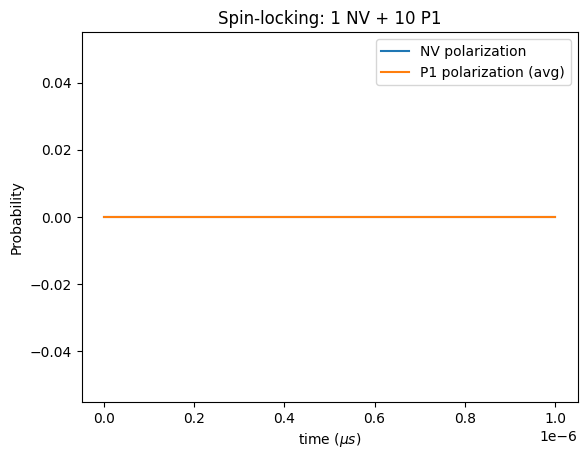

In [17]:
plt.plot(times, NV_pol_avg, label = 'NV polarization')
plt.plot(times, P1_pol_avg, label = 'P1 polarization (avg)')
plt.title('Spin-locking: 1 NV + 10 P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()

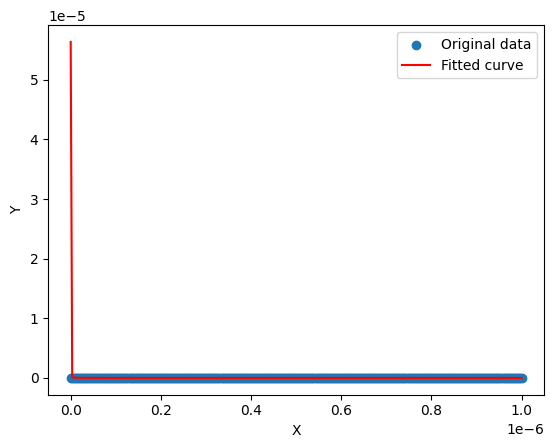

[5.63608577e-05 1.22520114e+02 1.53605219e-01]


In [18]:
# fit stretched exponential 

# Define the stretched exponential function
def stretched_exp(x, a, b, beta):
    return a * np.exp(-b * x ** beta)

# Fit the stretched exponential function to the data
popt, pcov = curve_fit(stretched_exp, times, NV_pol_avg, bounds=(0, np.inf))

# Plot the original data and the fitted curve
plt.scatter(times, NV_pol_avg, label='Original data')
plt.plot(times, stretched_exp(times, *popt), 'r-', label='Fitted curve')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()
print(popt)

In [19]:
n = 10
n_reps = 15
t_max = 1000e-9*6
times = np.linspace(0,t_max,6000)
# Divide the time list into 10 sublists
n_repol = 10;
sublist_length = len(times) // n_repol
time_sublists = [times[i * sublist_length: (i + 1) * sublist_length] for i in range(n_repol)]

NV_pol_avg = np.zeros(len(times))
P1_pol_avg = np.zeros(len(times))

NV_sublists = [NV_pol_avg[i * sublist_length: (i + 1) * sublist_length] for i in range(n_repol)]
P1_sublists = [P1_pol_avg[i * sublist_length: (i + 1) * sublist_length] for i in range(n_repol)]
list_P1 = [i for i in range(1, n+1)]

NV_pos = [0.0, 0.0, 0.0]

P1_pos = []

for i in range(n):
    r = 50*(np.random.rand()) + 70
    theta = np.random.rand()*np.pi*2
    phi = np.random.rand()*np.pi*2
    v =np.asarray([r*np.cos(theta)*np.sin(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)]) 
    P1_pos.append(v)

In [20]:
def reinitialize_NV(N, output):
    list_P1 = [i for i in range(1, N+1)]
    state = basis(2,0)
    
    for i in range(N):
        state_i = np.sqrt(np.abs(output.states[-1].ptrace(i + 1)[0][0][0]))*basis(2,0) + np.sqrt(np.abs(output.states[-1].ptrace(i + 1)[1][0][1]))*basis(2,1)
        
        state = tensor(state, state_i)
    return state

In [21]:
iterations = range(n_reps)
iterations_sub = range(n_repol)
for ii in range(n_reps):
    # part 1
    psi0 = basis(2,0)
    for i in range(n):
        psi0 = tensor(psi0, basis(2,random.randint(0, 1)))

    Ω_NV = 1*MHz
    Ω_P1 = 1*MHz*np.ones(n)
    δ_NV = 0
    δ_P1 = np.zeros(n)
    NV_pos = [0.0, 0.0, 0.0]

    P1_pos = []

    for i in range(n):
        r = 50*(np.random.rand()) + 70
        theta = np.random.rand()*np.pi*2
        phi = np.random.rand()*np.pi*2
        v =np.asarray([r*np.cos(theta)*np.sin(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)]) 
        P1_pos.append(v)

    H = H_tot(n, NV_pos, P1_pos, Ω_NV, Ω_P1, δ_NV, δ_P1)

    with tqdm(total=len(iterations_sub)) as pbar_sub:
        for jj in range(n_repol):
            t_list =  time_sublists[jj]
            result = mesolve(H, psi0, t_list, [], [], options=Options(nsteps=20000, method='bdf' ))

            for kk in range(len(result.states)):
                NV_pol_sum = NV_sublists[jj][kk]*(ii)
                NV_sublists[jj][kk] = (NV_pol_sum + np.abs(result.states[kk].ptrace(0)[0][0][0]))/(ii + 1)

                P1_pol_sum = P1_sublists[jj][kk]*(ii)
                P1_pol=0
                for kkk in range(n):
                    P1_pol += np.abs(result.states[kk].ptrace(kkk + 1)[0][0][0])
                P1_sublists[jj][kk] = (P1_pol_sum + P1_pol/n)/(ii+1)

            psi0 = reinitialize_NV(n, result)
            pbar_sub.update(1)

TypeError: H_tot() missing 1 required positional argument: 'option'

In [22]:
# Concatenate the sublists into a single list
total_time = [item for sublist in time_sublists for item in sublist]
NV_pol_avg = [item for sublist in NV_sublists for item in sublist]
P1_pol_avg = [item for sublist in P1_sublists for item in sublist]

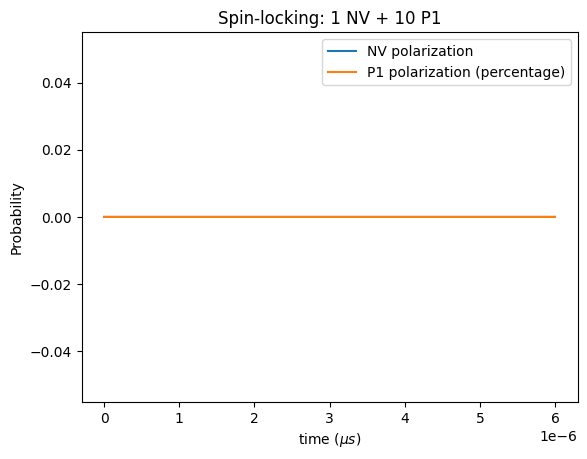

In [23]:
plt.plot(times, NV_pol_avg, label = 'NV polarization')
plt.plot(times, P1_pol_avg, label = 'P1 polarization (percentage)')
plt.title('Spin-locking: 1 NV + 10 P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()

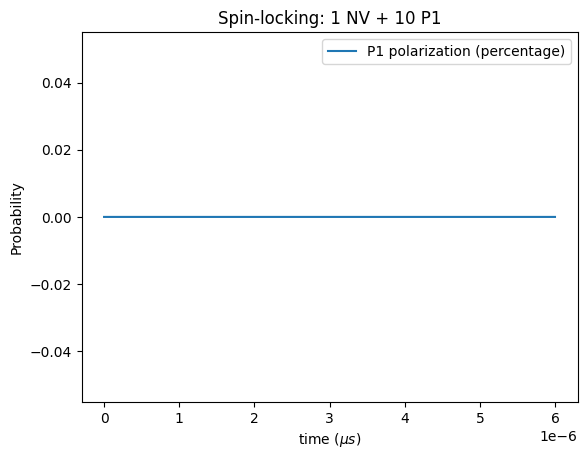

In [24]:
plt.plot(times, P1_pol_avg, label = 'P1 polarization (percentage)')
plt.title('Spin-locking: 1 NV + 10 P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()

# Switch Spin Lock Dynamics 


In [25]:
n_reps = 25
n = 10
times1 = np.linspace(0,2000e-9,300)
times2 = np.linspace(0,2000e-9,300)
NV_pol_avg1 = np.zeros(len(times1))
P1_pol_avg1 = np.zeros(len(times1))
NV_pol_avg2 = np.zeros(len(times2))
P1_pol_avg2 = np.zeros(len(times2))
iterations = range(n_reps)


with tqdm(total=len(iterations)) as pbar:
    for ii in range(n_reps):
        #print('Rep: ', ii, '\n') 

        Ω_NV = 1*MHz
        Ω_P1 = 1*MHz*np.ones(n)
        δ_NV = 0
        δ_P1 = np.zeros(n)
        NV_pos = [0.0, 0.0, 0.0]

        P1_pos = []

        for i in range(n):
            r = 50*np.random.rand() + 100
            theta = np.random.rand()*np.pi*2
            phi = np.random.rand()*np.pi*2
            v =np.asarray([r*np.cos(theta)*np.sin(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)]) 
            P1_pos.append(v)


        psi0 = basis(2,0)
        for i in range(n):
            psi0 = tensor(psi0, basis(2,random.randint(0, 1)))
            #psi0 = tensor(psi0, basis(2,1))
            
        H = H_tot(n, NV_pos, P1_pos, Ω_NV, Ω_P1, δ_NV, δ_P1, 'SQ')

        result = mesolve(H, psi0, times1, [], [], options=Options(nsteps=20000, method='bdf' ))

        for kk in range(len(result.states)):
            NV_pol_sum = NV_pol_avg1[kk]*(ii)
            NV_pol_avg1[kk] = (NV_pol_sum + np.abs(result.states[kk].ptrace(0)[0][0][0]))/(ii + 1)

            P1_pol_sum = P1_pol_avg1[kk]*(ii)
            P1_pol=0
            for kkk in range(n):
                P1_pol += np.abs(result.states[kk].ptrace(kkk + 1)[0][0][0])
            P1_pol_avg1[kk] = (P1_pol_sum + P1_pol/n)/(ii+1)
            
            
        psi0 = result.states[-1]
        
        H = H_tot(n, NV_pos, P1_pos, Ω_NV, Ω_P1, δ_NV, δ_P1, 'DQ')

        result = mesolve(H, psi0, times2, [], [], options=Options(nsteps=20000, method='bdf' ))

        for kk in range(len(result.states)):
            NV_pol_sum = NV_pol_avg2[kk]*(ii)
            NV_pol_avg2[kk] = (NV_pol_sum + np.abs(result.states[kk].ptrace(0)[0][0][0]))/(ii + 1)

            P1_pol_sum = P1_pol_avg2[kk]*(ii)
            P1_pol=0
            for kkk in range(n):
                P1_pol += np.abs(result.states[kk].ptrace(kkk + 1)[0][0][0])
            P1_pol_avg2[kk] = (P1_pol_sum + P1_pol/n)/(ii+1)

            
        pbar.update(1)

  0%|                                                                                           | 0/25 [00:02<?, ?it/s]


IndexError: invalid index to scalar variable.

In [ ]:
NV_pol_avg_A = NV_pol_avg
P1_pol_avg_A = P1_pol_avg

In [ ]:
times_end = times2 + times1[-1]
times = np.concatenate((np.asarray(times1), np.asarray(times_end)))
NV_pol_avg = np.concatenate((NV_pol_avg1, NV_pol_avg2))
P1_pol_avg = np.concatenate((P1_pol_avg1, P1_pol_avg2))

In [ ]:
plt.plot(times, NV_pol_avg, label = 'NV polarization')
plt.plot(times, P1_pol_avg, label = 'P1 polarization (avg)')
plt.title('Spin-locking: 1 NV + 10 P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()

In [ ]:

plt.plot(times, P1_pol_avg, label = 'P1 polarization (avg)')
plt.title('Spin-locking: 1 NV + 10 P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()

In [ ]:
# fit stretched exponential 

# Define the stretched exponential function
def stretched_exp(x, a, b, beta):
    return a * np.exp(-b * x ** beta)

# Fit the stretched exponential function to the data
popt, pcov = curve_fit(stretched_exp, times1, NV_pol_avg1, bounds=(0, np.inf))

# Plot the original data and the fitted curve
plt.scatter(times1, NV_pol_avg1, label='Original data')
plt.plot(times1, stretched_exp(times1, *popt), 'r-', label='Fitted curve')
plt.xlabel('t')
plt.ylabel('Signal')
plt.legend()
plt.show()
print(popt)

In [ ]:
# fit stretched exponential 

# Define the stretched exponential function
def stretched_exp(x, a, b, beta):
    return a * np.exp(-b * x ** beta)

# Fit the stretched exponential function to the data
popt, pcov = curve_fit(stretched_exp, times2, NV_pol_avg2, bounds=(0, np.inf))

# Plot the original data and the fitted curve
plt.scatter(times2, NV_pol_avg2, label='Original data')
plt.plot(times2, stretched_exp(times1, *popt), 'r-', label='Fitted curve')
plt.xlabel('Signal')
plt.ylabel('t')
plt.legend()
plt.show()
print(popt)

In [ ]:
n_reps = 25
n = 10
times1 = np.linspace(0,1000e-9,300)
times2 = np.linspace(0,3000e-9,300)
NV_pol_avg1 = np.zeros(len(times1))
P1_pol_avg1 = np.zeros(len(times1))
NV_pol_avg2 = np.zeros(len(times2))
P1_pol_avg2 = np.zeros(len(times2))
iterations = range(n_reps)


with tqdm(total=len(iterations)) as pbar:
    for ii in range(n_reps):
        #print('Rep: ', ii, '\n') 

        Ω_NV = 1*MHz
        Ω_P1 = 1*MHz*np.ones(n)
        δ_NV = 0
        δ_P1 = np.zeros(n)
        NV_pos = [0.0, 0.0, 0.0]

        P1_pos = []

        for i in range(n):
            r = 50*np.random.rand() + 100
            theta = np.random.rand()*np.pi*2
            phi = np.random.rand()*np.pi*2
            v =np.asarray([r*np.cos(theta)*np.sin(phi), r*np.sin(theta)*np.sin(phi), r*np.cos(theta)]) 
            P1_pos.append(v)


        psi0 = basis(2,0)
        for i in range(n):
            psi0 = tensor(psi0, basis(2,random.randint(0, 1)))
            #psi0 = tensor(psi0, basis(2,1))
            
        H = H_tot(n, NV_pos, P1_pos, Ω_NV, Ω_P1, δ_NV, δ_P1, 'SQ')

        result = mesolve(H, psi0, times1, [], [], options=Options(nsteps=20000, method='bdf' ))

        for kk in range(len(result.states)):
            NV_pol_sum = NV_pol_avg1[kk]*(ii)
            NV_pol_avg1[kk] = (NV_pol_sum + np.abs(result.states[kk].ptrace(0)[0][0][0]))/(ii + 1)

            P1_pol_sum = P1_pol_avg1[kk]*(ii)
            P1_pol=0
            for kkk in range(n):
                P1_pol += np.abs(result.states[kk].ptrace(kkk + 1)[0][0][0])
            P1_pol_avg1[kk] = (P1_pol_sum + P1_pol/n)/(ii+1)
            
            
        psi0 = result.states[-1]
        
        H = H_tot(n, NV_pos, P1_pos, Ω_NV, Ω_P1, δ_NV, δ_P1, 'DQ')

        result = mesolve(H, psi0, times2, [], [], options=Options(nsteps=20000, method='bdf' ))

        for kk in range(len(result.states)):
            NV_pol_sum = NV_pol_avg2[kk]*(ii)
            NV_pol_avg2[kk] = (NV_pol_sum + np.abs(result.states[kk].ptrace(0)[0][0][0]))/(ii + 1)

            P1_pol_sum = P1_pol_avg2[kk]*(ii)
            P1_pol=0
            for kkk in range(n):
                P1_pol += np.abs(result.states[kk].ptrace(kkk + 1)[0][0][0])
            P1_pol_avg2[kk] = (P1_pol_sum + P1_pol/n)/(ii+1)

            
        pbar.update(1)

In [ ]:
times_end = times2 + times1[-1]
times = np.concatenate((np.asarray(times1), np.asarray(times_end)))
NV_pol_avg = np.concatenate((NV_pol_avg1, NV_pol_avg2))
P1_pol_avg = np.concatenate((P1_pol_avg1, P1_pol_avg2))

In [ ]:
plt.plot(times, NV_pol_avg, label = 'NV polarization')
plt.plot(times, P1_pol_avg, label = 'P1 polarization (avg)')
plt.title('Spin-locking: 1 NV + 10 P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()

In [ ]:
times1 = np.linspace(0,2000e-9,300)
times2 = np.linspace(0,2000e-9,300)
times_end = times2 + times1[-1]
times_A = np.concatenate((np.asarray(times1), np.asarray(times_end)))

In [ ]:
plt.plot(times, P1_pol_avg - min(P1_pol_avg))
plt.plot(times_A, P1_pol_avg_A - min(P1_pol_avg_A))
plt.title('Spin-locking: 1 NV + 10 P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()

In [ ]:
plt.plot(times, NV_pol_avg - min(NV_pol_avg))
plt.plot(times_A, NV_pol_avg_A - min(NV_pol_avg_A))
plt.title('Spin-locking: 1 NV + 10 P1')
plt.xlabel(r'time ($\mu s$)')
plt.ylabel('Probability')
plt.legend()